# I. Traffic simulation for single-lane roads

In [115]:
import numpy as np
import matplotlib.pyplot as plt
class TrafficSimulation1():
    # set the relevant attributes for the class
    def __init__(self, road_len, traffic_density, max_v, prob_slowing, sum_velocity):
        self.road_len = road_len
        self.traffic_density = traffic_density
        self.max_v = max_v
        self.prob_slowing = prob_slowing
        self.road = np.full((self.road_len, 1), -1)
        self.next_road = np.full((self.road_len, 1), -1)
        self.sum_velocity = sum_velocity
    
    # set the initial state for the road
    def initial_state(self):     
        list_index = [i for i in range(0,self.road_len)]
        # randomly choose slots on the road where there are cars, such that the density equals the given density
        with_car = np.random.choice(list_index, size = int(self.road_len*self.traffic_density),replace=False)
        # randomly assign initial velocities to the cars
        for i in with_car:
            self.road[i] = 0

    # update rules 
    def update(self):
        self.next_road = np.full((self.road_len, 1), -1)
        for car in range(self.road_len):
            if self.road[car] != -1:
            # count the number of empty slots ahead
                space = 0
                for slot in range(1, self.road_len):
                    if self.road[(car+slot)%self.road_len] == -1:
                        space += 1
                    else:
                        break
            # acceleration
                if space > self.road[car] and self.road[car] < self.max_v:
                    self.road[car] = self.road[car] + 1
            # slowing down
                if space < self.road[car]:
                    self.road[car] = space
            # random slowing down
                if self.road[car] != 0:
                    if np.random.random() < self.prob_slowing:
                        self.road[car] -= 1
        # all the cars move
        for car in range(self.road_len):
            if self.road[car] != -1:
                self.next_road[(car + self.road[car])%self.road_len] = self.road[car]
        
        # update the road
        self.road = self.next_road
    def get_flow(self):    
        # the total velocities of all the cars, to calculate traffic flow later on
        for car in range(self.max_v):
            if self.road[car] > car:
                self.sum_velocity += 1
        
    
    # display the traffic
    def display(self):
        print(''.join('.' if x == -1 else str(x[0]) for x in self.road))

# II. Traffic simulation for double-lane roads
## 1. What is it?
- The traffic on the single-lane roads being simulated is represented by a one dimension cellular automaton with a periodic boundary. For the double-lane roads, we use two one dimensional cellular automata, with the same velocity update rules as the single-lane but with an additional update rule for the lane change.
- The length of the lanes equals the number of slots in each lane, whose values range from -1 to a pre-determined maximum velocity value. If there is no car in a lot, its value is -1. If there is a car in a slot, its value corresponds with the velocity of the car.
- The cars change lanes simultaneously sideways. The velocities of the cars are updated simultaneously according to the new lane configuration, and only after they are updated will the cars start to move at their new velocities.
## 2. What are the update rules?
### a. General assumptions
- All the cars move and stop simultaneously
- All the car drivers follow the traffic rules
- If there is a change in the lane of a car, it updates its velocity according to the situation in the new lane
### b. Lane changing rules
- A driver will look ahead and behind for a certain distance to determine the necessary gap that makes the change of lanes possible. Her/his car will change its lane if and only if all of the following conditions are met:
- (1.1) The number of empty slots ahead of it in the current lane is less than its current velocity plus 1.
- (1.2) There is no car in the same slot in the other lane, and the number of empty slots ahead of it in the other lane is more than its current velocity plus 1.
- (1.3) The number of empty slots behind it in the other lane is more than the maximum velocity.
- (1.4) The probability of lane change is 0.8, so if a random number is withdrawn, it has to lie between 0 and 0.8
- Of course, how far ahead and behind the drivers look is flexible, but the distances given above are to make sure the cars will not collide with each other and to avoid certain scenario. For example, for (1.1), if the driver only looks ahead a distance of the car's velocity, in case of heavy traffic when the car cannot move (velocity = 0) because there is another car right ahead of it, even if there is space in the other lane, the car will still not change lane (because the distance is equal to, not less than the current velocity). This does not make much sense in real life. Another scenario we want to avoid is the ping pong scenario where there is heavy traffic on one lane, and there is almost no traffic on the other, without (1.4), all the cars from one lane will move to the other altogether and this situation keeps happening, making the traffic in two lanes unbalanced.
### c. Velocity update rules
- These rules are applied in order only after the cars have updated their lanes. These rules consider the new lane of the cars, whether it's still the current lane or the other lane.
- (2.1) Acceleration: If the empty space ahead is greater than the current velocity, and the current velocity is smaller than the maximum velocity, increase the velocity by 1.
- (2.2) Slowing down: If the empty space ahead is smaller than the current velocity, decrease the velocity to the empty space.
- (2.3) Random slowing down: A number between 0 and 1 is drawn, if it is smaller than the slowing down probability, the car slows down by 1.
- This random deceleration is necessary because in real life, a car may slow down due to random incidents such as the driver startled or a hole on the road.

In [101]:
class TrafficSimulation2():
    # set the relevant attributes for the class
    def __init__(self, road_len, traffic_density, max_v, prob_slowing, sum_velocity, prob_change):
        self.road_len = road_len
        self.traffic_density = traffic_density
        self.max_v = max_v
        self.prob_slowing = prob_slowing
        self.road = np.full((self.road_len, 2), -1)
        self.next_road = np.full((self.road_len, 2), -1)
        self.sum_velocity = sum_velocity
        self.prob_change = prob_change
    # set the initial state for the road
    def initial_state(self):  
        list_index = [i for i in range(0,self.road_len)]
        # for each lane
        for j in range(2):
            # randomly choose slots on the road where there are cars, such that the density equals the given density
            with_car = np.random.choice(list_index, size = int(self.road_len*self.traffic_density),replace=False)
            # randomly assign initial velocities to the cars
            for i in with_car:
                lane = np.random.choice([0, 1], size = 1)
                if self.road[i][lane] == -1:
                    self.road[i][lane] = 0
                elif self.road[i][1-lane] == -1:
                    self.road[i][1-lane] = 0
                
                
    # update rules
    def update(self):
        self.next_road = np.full((self.road_len, 2), -1)
        # create a list that stores index of cars that will change lane
        change_list = [0, 1]
        # for each lane
        for j in range(2):
            # list of cars that will change lane in each lane
            change_list_each = []
            for car in range(self.road_len):
                if self.road[car][j] != -1:
                    # count the number of empty slots ahead in the current lane
                    space = 0
                    for slot in range(1, self.road_len):
                        if self.road[(car+slot)%self.road_len][j] == -1:
                            space += 1
                        else:
                            break
                    # count the number of empty slots ahead in the other lane
                    space_2 = 0
                    for slot in range(1, self.road_len):
                        if self.road[(car+slot)%self.road_len][1-j] == -1:
                            space_2 += 1
                        else:
                            break
                    # count the number of empty slots behind in the other lane
                    space_3 = 0
                    for slot in range(1, self.road_len):
                        if self.road[(car-slot)%self.road_len][1-j] == -1 and self.road[car][1-j] == -1:
                            space_3 += 1
                        else:
                            break
                    # check the condition for changing lane and apply update rule if lane is changed
                    if self.road[car][j] + 1 > space and self.road[car][j] + 1 < space_2 and self.max_v < (space_3) and (np.random.random() < self.prob_change):
                        change_list_each.append(car)
            change_list[j] = change_list_each
#         print("change list", change_list)
        for j in range(2):
            for car in range(self.road_len):
                # if a car is changing lane
                if car in change_list[j]:
                    self.road[car][1-j] = self.road[car][j]
                    self.road[car][j] = -1
#         print("new lane")
#         for j in range(2):
#             print(''.join('.' if x == -1 else str(x) for x in self.road[:,j]))            
        for j in range(2):
            for car in range(self.road_len):
                if self.road[car][j] != -1:  
                    space_now = 0
                    for slot in range(1, self.road_len):
                        if self.road[(car+slot)%self.road_len][j] == -1:
                            space_now += 1
                        else:
                            break
                    # acceleration
                    if space_now > self.road[car][j] and self.road[car][j] < self.max_v:
                        self.road[car][j] = self.road[car][j] + 1
                    # slowing down
                    if space_now < self.road[car][j]:
                        self.road[car][j] = space_now
                    # random slowing down
                    if self.road[car][j] != 0 and self.road[car][j] != -1:
                        prob = np.random.random()
                        if prob < self.prob_slowing:
                            self.road[car][j] -= 1    
        # all the cars move in both lanes
        for j in range(2):
            for car in range(self.road_len):
                if self.road[car][j] != -1:
                    self.next_road[(car + self.road[car][j])%self.road_len][j] = self.road[car][j]
        # update the road            
        self.road = self.next_road
    def get_flow(self):    
        # the total velocities of all the cars, to calculate traffic flow later on
        for j in range(2):
            for car in range(self.max_v):
                if self.road[car][j] > car:
                    self.sum_velocity += 1
        
    # display the traffic    
    def display(self):
#         print("new road")
        for j in range(2):
            print(''.join('.' if x == -1 else str(x) for x in self.road[:,j]))

Progress: 100/100
[----------------------------------------------------------------------------------------------------]


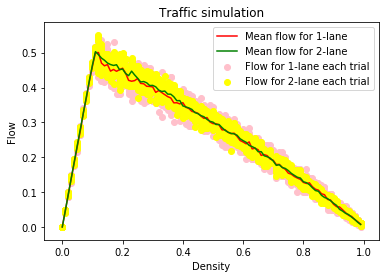

In [102]:
from IPython.display import clear_output
def Simulation(road_length, simulation_time, steps):
    # averaged flow at each density
    list_flow_1 = []
    list_density_1 = [i/100 for i in range(0,100)]
    list_flow_2 = []
    list_density_2 = [i/100 for i in range(0,100)]
    # flow at each simulation for each density
    scatter_density_1 = []
    scatter_flow_1 = []
    scatter_density_2 = []
    scatter_flow_2 = []
    progress = 0
    # for each density from 0 to 1, step of 0.01
    for i in range(0,100):
        progress += 1
        average_flow_1 = 0
        for j in range(simulation_time):
        # create an instance of traffic simulation
            traffic1 = TrafficSimulation1(road_len=road_length,traffic_density=i/100, max_v=5, prob_slowing=0.3, sum_velocity=0)
            traffic1.initial_state()
            scatter_density_1.append(i/100)
        # update the traffic at each time step
            for k in range(50):
                traffic1.update()
            for m in range(steps):
                traffic1.update()
                traffic1.get_flow()
            # flow of traffic
            flow1 = traffic1.sum_velocity / (steps)
            average_flow_1 += flow1
            scatter_flow_1.append(flow1)
        average_flow_1 = average_flow_1 / simulation_time
        list_flow_1.append(average_flow_1)
    
        average_flow_2 = 0
        for j in range(simulation_time):
        # create an instance of traffic simulation
            traffic2 = TrafficSimulation2(road_len=road_length,traffic_density=i/100, max_v=5, prob_slowing=0.3, sum_velocity=0, prob_change=0.8)
            traffic2.initial_state()
            scatter_density_2.append(i/100)
            # update the traffic at each time step
            for k in range(50):
                traffic2.update()
            for m in range(steps):
                traffic2.update()
                traffic2.get_flow()
            # flow of traffic
            flow2 = traffic2.sum_velocity / (steps*2)
            average_flow_2 += flow2
            scatter_flow_2.append(flow2)
        average_flow_2 = average_flow_2 / simulation_time
        list_flow_2.append(average_flow_2)
        
        clear_output(wait=True)
        print("Progress: {}/{}".format(progress,100))
        print("[",end="")
        for i in range(progress):
            print("-",end="")
        for j in range(100-progress):
            print(" ",end="")
        print("]")
    # draw a plot of flow against density
    plt.plot(list_density_1, list_flow_1, color="red", label="Mean flow for 1-lane")
    plt.plot(list_density_2, list_flow_2, color="green", label="Mean flow for 2-lane")
    plt.scatter(scatter_density_1, scatter_flow_1, color="pink", label="Flow for 1-lane each trial")
    plt.scatter(scatter_density_2, scatter_flow_2, color="yellow", label="Flow for 2-lane each trial")    
    plt.xlabel("Density")
    plt.ylabel("Flow")
    plt.title("Traffic simulation")
    plt.legend()
    plt.show()
    
    
Simulation(200,20,200)

In [123]:
# Visualize 2-lane traffic model
def Visualize2(road_length, steps):
    # create an instance of the traffic simulation
    traffic2 = TrafficSimulation2(road_len=road_length,traffic_density=0.2, max_v=5, prob_slowing=0.3, sum_velocity=0, prob_change = 0.8)
    traffic2.initial_state()
    # start to calculate the flow from step 11
    for i in range(10):
        traffic2.update()
    for step in range(steps):
        print ("step", (step + 11))
        traffic2.update()
        traffic2.display()
Visualize2(100, 50)

step 11
.5......4............3...30...2...1..2..1.1...........2....3......5..1...2.1.......4.......5........
4...........5....4.1..2...3....30.00...2....2.1..1....2.............5....2....1..1.1....2....3......
step 12
.....4......4..........2.00......3..2.1.0...2...........2.....3.....2.1..0..1...........5.......5...
.....5..........40...2...3....40.100......3..1..2..2.....3.............3....3...2.1..2.....3....3...
step 13
.5........5......5......10.1.......20..10......3...........3.....3...1.1..1...2.............4.......
4........4......0.1.....3....40.100.1.......2..2..2...3......4.............4...3.1..2..2......3.....
step 14
.....4.........5......5.0.1..2.....00..0.1.........4...........4.....4..1...2....3...............5..
.....5........5..1..2......3.0.1000...2......1...2...3...3.......4.....2.....2..1.1...2...3.......4.
step 15
..5.......5.........5.0..1..2..2...00...1..2............5..........4...2..2....3.....4..............
..4......4......2..2...3...0..1000.1.....3....1....

In [121]:
# Visualize 1-lane traffic model
def Visualize1(road_length, steps):
    # create an instance of the traffic simulation
    traffic1 = TrafficSimulation1(road_len=road_length,traffic_density=0.2, max_v=5, prob_slowing=0.3, sum_velocity=0)
    traffic1.initial_state()
    # start to calculate the flow from step 11
    for i in range(10):
        traffic1.update()
    for step in range(steps):
        traffic1.update()
        traffic1.display()
Visualize1(100, 50)

0.0.1.1...1..2.........4.........4.......4............20.1...1......2..20...2.......3...3..........5
.1.10...2...2...3...........5.........5.......5.......0.1.1....2......200......3.......3....4......0
10.0.1.....3...3...3.............5........4.......4....10...2.....3...00.1.........4.......4.....5..
00..1..2......3..2....3...............5........5......40.1.....3....2.0.1.1............4........5.1.
0.1...2...3....1...2.....3.................5........5.00...2......3.0.0.0...2..............4....0..1
.1..2....3....4..2....3.....3...................5....10.1....2.....1.1.1.1....2................40..0
1..2..2......4..2...3.....4....3....................40.1.1......3...1.10...2.....3.............0.1..
.1...2...3.....2..2.....4.....4....4................00.0...2......2..10.1.....3......4.........0...2
1..2....3....4...2...3.......5....4.....5...........0.10......3....1.00...2.......4......4......1...
.1....3.....4...3...3....4.......4....4......5.......100..........4.10.1.....3.........5...